In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from datetime import date

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from operator import add
import json
from matplotlib.backends.backend_pdf import PdfPages


data = pd.read_excel('/content/Final_Data (1) (1) (1).xlsx')

data['stdev_Copper'] = data['LR_Cop'].rolling(window=30, center=False).std()
data['Volatility_Copper'] = data['stdev_Copper'] * (252**0.5)
data['Volatility_Copper'] = data['Volatility_Copper']*100
data['stdev_Tin'] = data['LR_Tin'].rolling(window=30, center=False).std()
data['Volatility_Tin'] = data['stdev_Tin'] * (252**0.5)
data['stdev_Nickel'] = data['LR_Nic'].rolling(window=30, center=False).std()
data['Volatility_Nickel'] = data['stdev_Nickel'] * (252**0.5)
data['stdev_Alluminium'] = data['LR_All'].rolling(window=30, center=False).std()
data['Volatility_Alluminium'] = data['stdev_Alluminium'] * (252**0.5)
data['stdev_Zinc'] = data['LR_Zinc'].rolling(window=30, center=False).std()
data['Volatility_Zinc'] = data['stdev_Zinc'] * (252**0.5)
data['stdev_Lead'] = data['LR_Lead'].rolling(window=30, center=False).std()
data['Volatility_Lead'] = data['stdev_Lead'] * (252**0.5)
data['Volatility_Tin'] = data['Volatility_Tin']*100
data['Volatility_Nickel'] = data['Volatility_Nickel']*100
data['Volatility_Alluminium'] = data['Volatility_Alluminium']*100
data['Volatility_Zinc'] = data['Volatility_Zinc']*100
data['Volatility_Lead'] = data['Volatility_Lead']*100

data.dropna(inplace=True)
symbols = ['Volatility_Copper','Volatility_Tin','Volatility_Nickel','Volatility_Alluminium','Volatility_Lead','Volatility_Zinc']
window_sizes = [5, 9, 13, 22]


In [ ]:
def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))


def window_transform(time_series, window_size):
    X = []
    y = []
    for i in range(len(time_series) - window_size):
        X.append(time_series[i:i + window_size])
        y.append(time_series[i + window_size])

    return np.array(X), np.array(y)


def make_lstm_model(window_size):
    model_lstm = Sequential()
    model_lstm.add(LSTM(256, input_shape=(window_size, 2), activation='relu', kernel_initializer='lecun_uniform',return_sequences=True))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(128, input_shape=(window_size, 1), activation='relu', kernel_initializer='lecun_uniform',return_sequences=False))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(1, activation='linear'))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')

    return model_lstm



def test_model(model, X_train, X_test, y_train, y_test):
    y_pred_test_ann = model.predict(X_test)
    y_train_pred_ann = model.predict(X_train)
    r2_train = mse(y_train, y_train_pred_ann)
    r2_test = mse(y_test, y_pred_test_ann)

    return r2_train, r2_test



Epoch 1/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0114
Epoch 2/100
85/85 [==============================] - 1s 12ms/step - loss: 0.0043
Epoch 3/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0026
Epoch 4/100
85/85 [==============================] - 1s 12ms/step - loss: 0.0024
Epoch 5/100
85/85 [==============================] - 1s 12ms/step - loss: 0.0022
Epoch 6/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0022
Epoch 7/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 8/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0019
Epoch 9/100
85/85 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 10/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 11/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0016
Epoch 12/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0016
Epoch 13/100
85/85 [=====

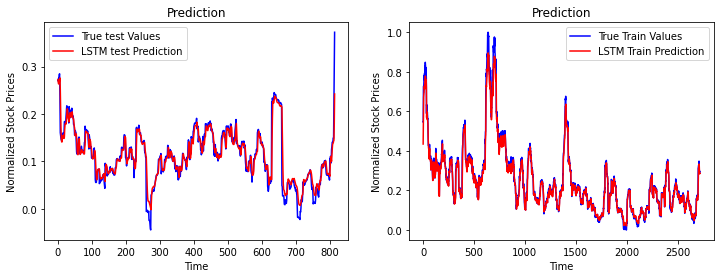

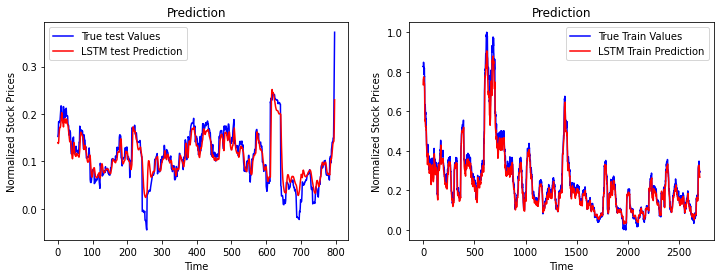

In [ ]:
output=pd.DataFrame()
output_train=pd.DataFrame()
for sym in symbols: 
  df = data[sym]
  df.index = data['Timestamp']
  df=pd.DataFrame(df)
  split_date = pd.Timestamp('01-01-2017')
  train = df.loc[:split_date]
  test = df.loc[split_date:]            
  sc = MinMaxScaler()
  train_sc = sc.fit_transform(train)
  test_sc = sc.transform(test)
  ann = []
  gru = []
  lstm = []
  cnn = []
  output[sym + "_" + "True_test"] = pd.Series(np.reshape(test_sc, ( -1)))
  output_train[sym + "_" + "True_train"] = pd.Series(np.reshape(train_sc, ( -1)))
  for win_sz in window_sizes:
    ann_result = []
    gru_result = []
    lstm_result = []
    cnn_result = []
    pred_ANN = []
    pred_LSTM = []
    pred_GRU = []
    pred_CNN = []
    pred_LSTM_train=[]
    X_train, y_train = window_transform(train_sc, win_sz)
    X_test, y_test = window_transform(test_sc, win_sz)
    X_tr_t = X_train.reshape(X_train.shape[0], win_sz, 1)
    X_tst_t = X_test.reshape(X_test.shape[0], win_sz, 1)
    for i in range(5):
      model = make_lstm_model(win_sz)
      early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
      history_model_lstm = model.fit(X_tr_t, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False,callbacks=[early_stop])

      train_acc, test_acc = test_model(model, X_tr_t, X_tst_t, y_train, y_test)
      y_pred_test_LSTM = model.predict(X_tst_t)
      y_pred_test_LSTM_train = model.predict(X_tr_t)
      lstm_result.append(test_acc)

      pred_LSTM.append(y_pred_test_LSTM)
      pred_LSTM_train.append(y_pred_test_LSTM_train)
    
  
    lstm.append([win_sz, min(lstm_result), np.mean(lstm_result), np.std(lstm_result)])
    

  
    plot_lstm = [0] * len(pred_LSTM[0])
    for pred in pred_LSTM:
        plot_lstm = list(map(add, plot_lstm, pred))

    for i in range(len(plot_lstm)):
        plot_lstm[i] = plot_lstm[i] / 5

    plot_lstm_train = [0] * len(pred_LSTM_train[0])
    for pred in pred_LSTM_train:
        plot_lstm_train = list(map(add, plot_lstm_train, pred))

    for i in range(len(plot_lstm_train)):
        plot_lstm_train[i] = plot_lstm_train[i] / 5
    
    output[sym + "_" + str(win_sz) + "_test_LSTM"] = pd.Series(np.reshape(plot_lstm, (-1)))
    output_train[sym + "_" + str(win_sz) + "_train_LSTM"] = pd.Series(np.reshape(plot_lstm_train, (-1)))
    output[sym + "_" + str(win_sz) + "_test_real_LSTM"] = pd.Series(np.reshape(y_test, (-1)))
    output_train[sym + "_" + str(win_sz) + "_train_real_LSTM"] = pd.Series(np.reshape(y_train, (-1)))
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax1.plot(y_test, '-', label='True test Values', color='b')
    ax1.plot(plot_lstm, label='LSTM test Prediction', color='r')
    ax1.set_title("Prediction")
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Normalized Stock Prices')
    ax1.legend()

    ax2.plot(y_train, '-', label='True Train Values', color='b')
    ax2.plot(plot_lstm_train, label='LSTM Train Prediction', color='r')
    ax2.set_title("Prediction")
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Normalized Stock Prices')
    ax2.legend()
output.to_excel('output.xlsx')   
output_train.to_excel('output_train.xlsx')   

In [ ]:
df1 = output_train
df1.index = data['Timestamp'].iloc[0:df1.shape[0]].values
df2 = output
df2.index = data['Timestamp'].iloc[df1.shape[0]:(df1.shape[0]+df2.shape[0])].values

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df2, title = "Download CSV file", filename = "Copper_test.csv"):
    csv = df2.to_csv(index=True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(df2)

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df1, title = "Download CSV file", filename = "Copper_train.csv"):
    csv = df1.to_csv(index=True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(df1)